## Language Detection Benchmark
This notebook is a suppliment to my language detection project. I use [langdetect](https://pypi.org/project/langdetect/), a python port for Google's language detection library, to compare its results to those of my models.<br><br>
It turns out that langdetect is non-deterministic, meaning that I get different results each time I run this script. 

In [1]:
import pandas as pd
import numpy as np
from time import time
from sklearn.preprocessing import LabelBinarizer
#make sure langdetect is installed. Uncomment:
#!pip install langdetect
from langdetect.detector_factory import init_factory
from presentation import one_hot_encode, compute_results, plot_results, plot_confusion
import seaborn as sns
sns.set(font_scale=2)

In [2]:
#load validation set
test_set = pd.read_csv('europarl.test', sep='\t', header=None)
test_set.columns = ['lang', 'text']
languages = test_set.columns

#one-hot-encode languages for log-loss computation
lb = LabelBinarizer()
Y = lb.fit_transform(test_set.lang)

In [3]:
init_factory()
from langdetect.detector_factory import _factory

def predict(text):
    """Creates detector and returns a set of probabilities
    for the input text."""
    detector = _factory.create()
    detector.PROB_THRESHOLD=0
    detector.append(text)
    return detector.get_probabilities()

def vectorize_prediction(prediction, binarizer):
    """Takes the output of predict function and transforms it
    into a probability vector compatible with binarizer's classes.
    """
    pred_dict = dict()
    for elem in prediction:
        splt = str(elem).split(':')
        lang = splt[0]
        prop = float(splt[1])
        pred_dict[lang] = prop
    vec = []
    for lang in binarizer.classes_:
        try:
            vec.append(pred_dict[lang])
        except KeyError:
            vec.append(0)
    return np.array(vec)

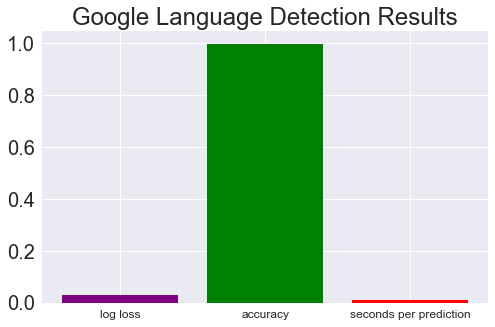

Accuracy: 99.72%


In [4]:
predictions = []
t1 = time()
for i, row in test_set.iterrows():
    pred = vectorize_prediction(predict(row.text), lb)
    #Force probability sum to zero.
    tot = 1-pred.sum()
    add = tot/len(lb.classes_)
    pred += add
    predictions.append(pred)
predictions = np.array(predictions)
prediction_time = time() - t1
spp = prediction_time / len(test_set)

loss, accuracy = compute_results(Y, predictions)
plot_results(loss, accuracy, spp, 'Google Language Detection Results')
print('Accuracy: {}%'.format(round(100 * accuracy, 2)))

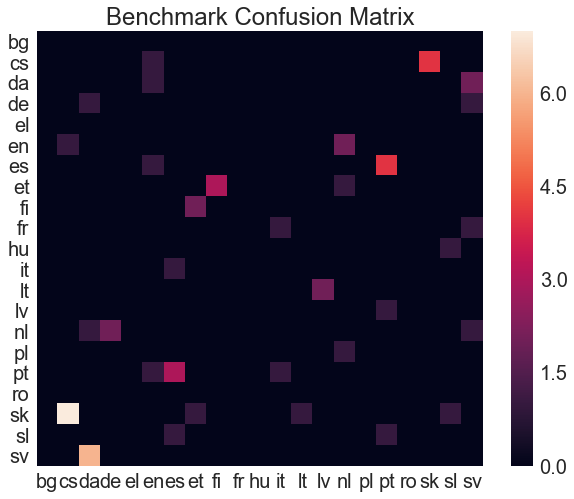

In [5]:
class EncoderDecoder(object):
    """Decodes and encodes numbers as languages
    and vis versa."""
    def __init__(self, binarizer):
        self.classes = binarizer.classes_
        self.langs = self.classes
        
    def encode(self, lang):
        langs = list(self.classes)
        idx = langs.index(lang)
        return idx
    
    def decode(self, num):
        try:
            return self.classes[num]
        except KeyError:
            print('Unable to decode index: ', num)
            raise KeyError('Index not in classes.')
            
decoder = EncoderDecoder(lb)
conf = plot_confusion(Y, predictions, decoder, title='Benchmark Confusion Matrix')

### Discussion
Google's language detection library performs comparably with mine in terms of accuracy. In practice, this approach is the most practical as the rate of predictions is much faster.<br><br>

### Ensembling Google and Markov Chain Models
It's important to note that the confusions made by the Google model appear in different languages than my model. If we want to improve accuracy further, we can build an ensemble model that combines the outputs of these multiple models to get the right answer in confusing cases.

In [6]:
#Load results from Markov Chain experiment
pred1, pred3, pred5 = np.load('pred1.npy'), np.load('pred3.npy'), np.load('pred5.npy')

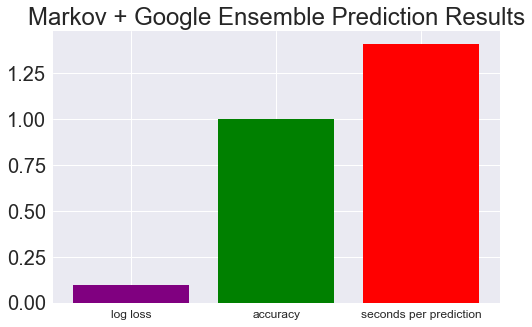

Accuracy: 99.93%


In [7]:
#Average likelihoods from all predictions
ensemble = (predictions + pred1 + pred3 + pred5)/4
markov_ens_spp = 1.3977418684652632 #total spp of markov chain ensemble
spp_ensemble = markov_ens_spp + spp
ens_loss, ens_accuracy = compute_results(Y, ensemble)
plot_results(ens_loss, ens_accuracy, spp_ensemble, 'Markov + Google Ensemble Prediction Results')
print('Accuracy: {}%'.format(round(100 * ens_accuracy, 2)))

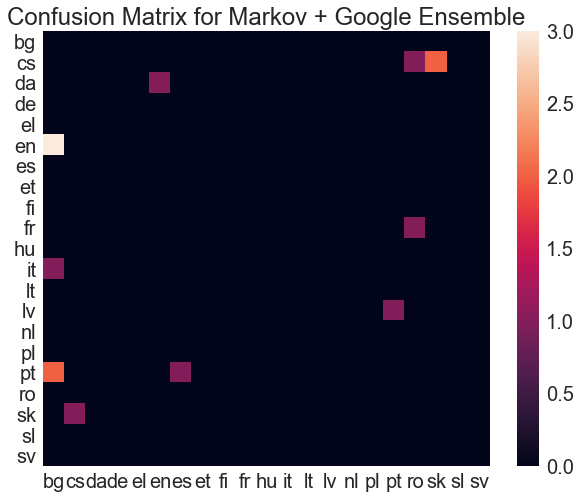

In [8]:
mat = plot_confusion(Y, ensemble, decoder, 'Confusion Matrix for Markov + Google Ensemble')

There you have it. By combining information from all of the predictions, we are able to achieve 99.94% accuracy on the validation set.